# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-lc'
epochs = 10
batch_size = 8
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(least_confident_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6763, Accuracy: 0.9137, F1 Micro: 0.937, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3077, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2448, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2255, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1898, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1761,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6117, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3755, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3024, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2328, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2099, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1901, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2095,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2997, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1412, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1346, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1487, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1426, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.1624, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462, Accuracy: 0.9688, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4201, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1558, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1635, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1248, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.1302, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 10/10, Train Loss: 0.1037, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1919, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1589, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1394, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.1456, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.41, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.218, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1985, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1658, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1453, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1315, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1158, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6484
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1784, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1387, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.1208, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.1015, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1933, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1961, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.9747, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3595, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1429, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.743
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9598, F1 Micro: 0.9694, F1 Macro: 0.7411
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0612, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7356
Epoch 10/10, Train Loss: 0.0704, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3475, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1944, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7781
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1941, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9792, F1 Micro: 0.9842, F1 Macro: 0.8243
Epoch 10/10, Train Loss: 0.056, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.188, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7393
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.752
Epoch 10/10, Train Loss: 0.0708, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0615, Accuracy: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3347, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0622, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3049, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7394
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0488, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7214
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7977
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 10/1

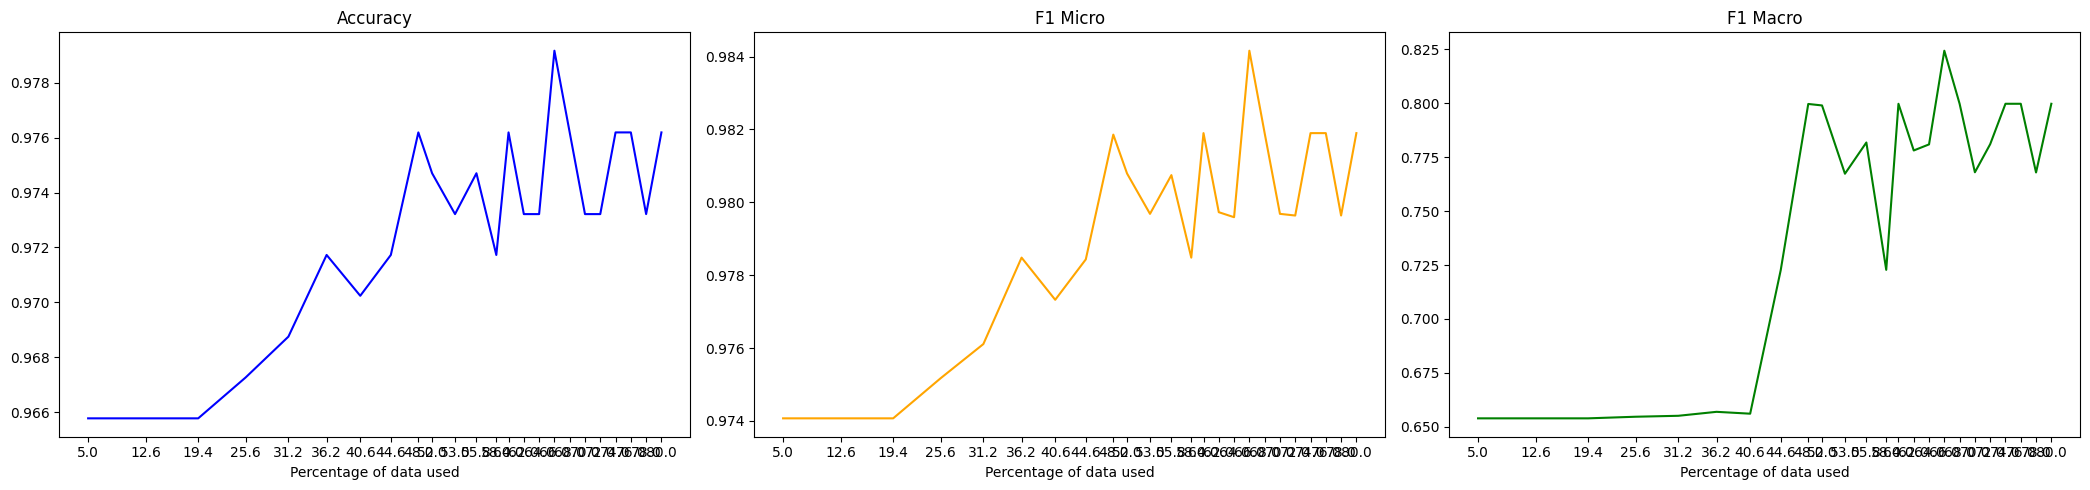

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7235, Accuracy: 0.9062, F1 Micro: 0.9317, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4066, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3144, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2063,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6358, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2855, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2309, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2541, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1912, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1878, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1911,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2019, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1618, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1576,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4934, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1999, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.152, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1544,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.451, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1624, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1594, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1297, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4092, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2053, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9732, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1626, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1348, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.653
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7643
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2222, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1341, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.78
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0615, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.791
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7974
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7468
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7463
Epoch 10/10, Train Loss: 0.0528, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1953, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8235
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.179, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.793
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9747, F1 Micro: 0.98

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9643, F1 Micro: 0.9724, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.7949
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.793
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.346, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7974
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1933, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7602
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1932, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7942
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3303, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8005
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3133, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7503
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7809
Epoch 10/10, Train Loss: 0.04, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3138, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7983
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7902
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.302, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1887, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8005
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7773
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.161, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7229
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0

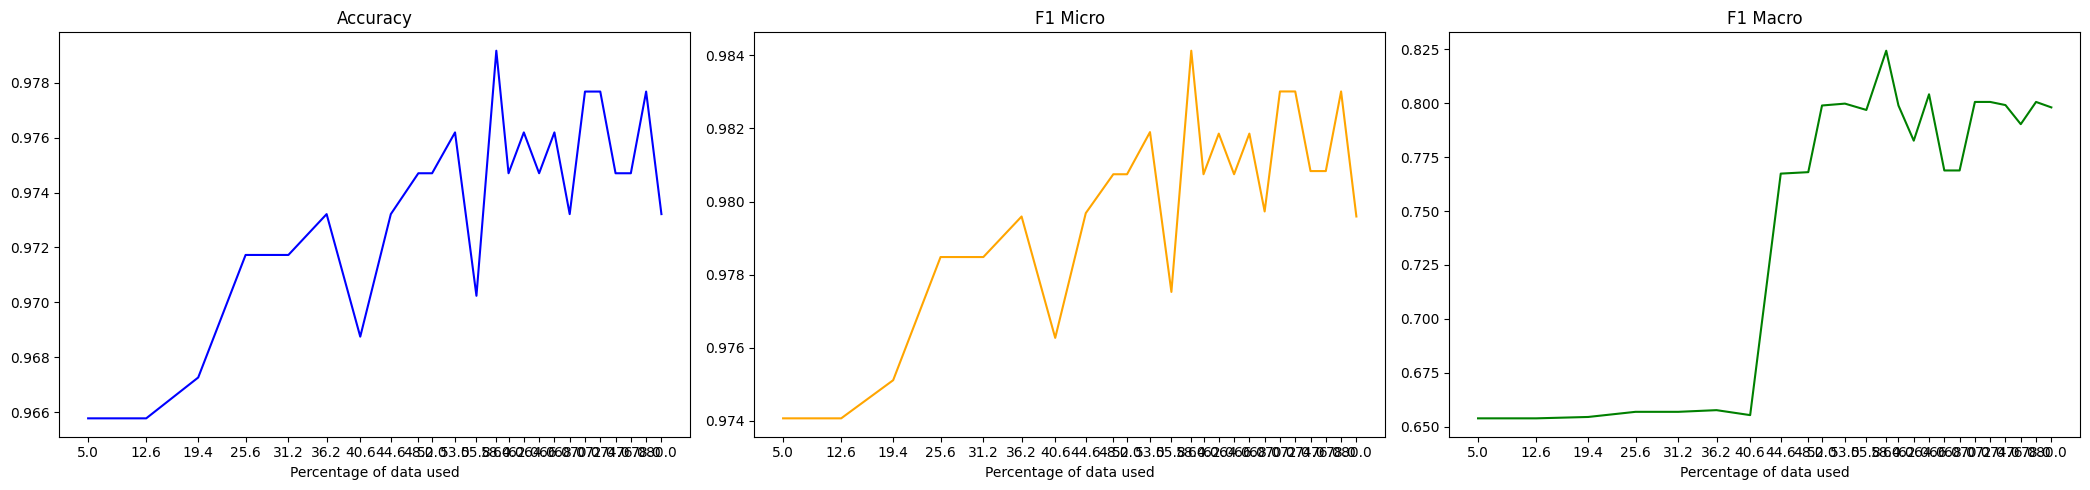

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6137, Accuracy: 0.9524, F1 Micro: 0.9635, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4556, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3444, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1986, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2051, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1674,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5544, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3341, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2067, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2027, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1643,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4695, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2054, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1807, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1421, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1545, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1952, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1586, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.1619, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1336, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1821, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1378, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1392, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.1305, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.6536
Epoch 10/10, Train Loss: 0.0919, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6476
Epoch 7/10, Train Loss: 0.1393, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Epoch 10/10, Train Loss: 0.0734, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1571, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.1174, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6474
Epoch 10/10, Train Loss: 0.0704, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6474
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3535, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2079, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.6585
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9494, F1 Micro: 0.9605, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3286, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1839, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.6503
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6492
Epoch 10/10, Train Loss: 0.0758, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3283, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6577
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3331, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1459, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.9747, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6474
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6568
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6894
Epoch 10/10, Train Loss: 0.0658, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1318, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.6495
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9598, F1 Micro: 0.9689, F1 Macro: 0.6492
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3119, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.6585
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7383
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.6539
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9628, F1 Micro: 0.9715, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.0466, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1795, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.6559
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0415, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7336
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7559
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3225, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.7367
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3052, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9732, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2994, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7809
Epoch 10/10, Train Loss: 0.0498, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1737, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7243
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8005
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9792, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9628, F1 Micro: 0.9715, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 10/10

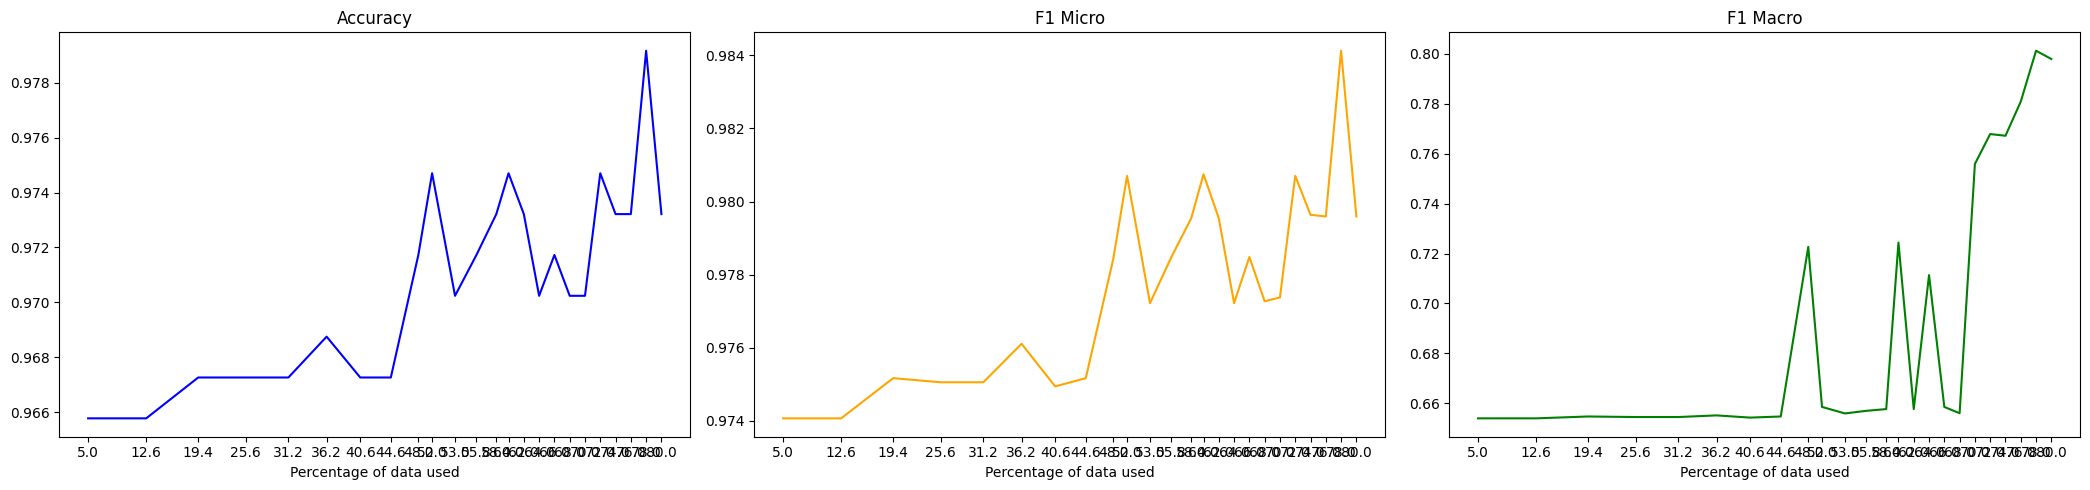

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6047, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2584, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1922, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1935, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5271, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3298, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2004, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2031, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1895, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1785, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1973, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1501, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1597, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4222, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1924, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1459, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1663, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3999, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2111, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1513, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.143, Accuracy: 0.9658, F1 Micro: 0.974

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1599, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1624, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1166, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2021, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1478, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1156, Accuracy: 0.9673, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.147, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.144, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Epoch 9/10, Train Loss: 0.1242, Accuracy: 0.9509, F1 Micro: 0.9618

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1999, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1732, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.6512
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.719
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3335, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1939, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1637, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1288, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.102, Accuracy: 0.9613, F1 Micro: 0.9705, F1 Macro: 0.6993
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3246, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1602, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.146, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9702, F1 Micro: 0.9775

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3214, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1385, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7485
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7764
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.7725
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3096, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1604, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9598, F1 Micro: 0.9698, F1 Macro: 0.7293
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7738
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9568, F1 Micro: 0.9669, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1904, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6527
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9717, F1 Micro: 0.9787, F1 Macro: 0.7888
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9613, F1 Micro: 0.971, F1 Macro: 0.7302
Epoch 10/10, Train Loss: 0.0529, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3004, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1988, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1609, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.8203
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7984
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3021, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9539, F1 Micro: 0.9656, F1 Macro: 0.7095
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9598, F1 Micro: 0.9695, F1 Macro: 0.7468
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.7544
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9598, F1 Micro: 0.9694, F1 Macro: 0.7616
Epoch 10/10, Train Loss: 0.0524, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2915, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1459, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7329
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2843, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.187, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1239, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7331
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7465
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9494, F1 Micro: 0.9608, F1 Macro: 0.7535
Epoch 10/10, Train Loss: 0.0563, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.285, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9747, F1 Micro: 0.9809, F1 Macro: 0.8221
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2915, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1737, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7436
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.8209
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1472, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.7547
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1659, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9717, F1 Micro: 0.9787, F1 Macro: 0.7888
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7403
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7326
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.8209
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.8181
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7585
Epoch 10/10

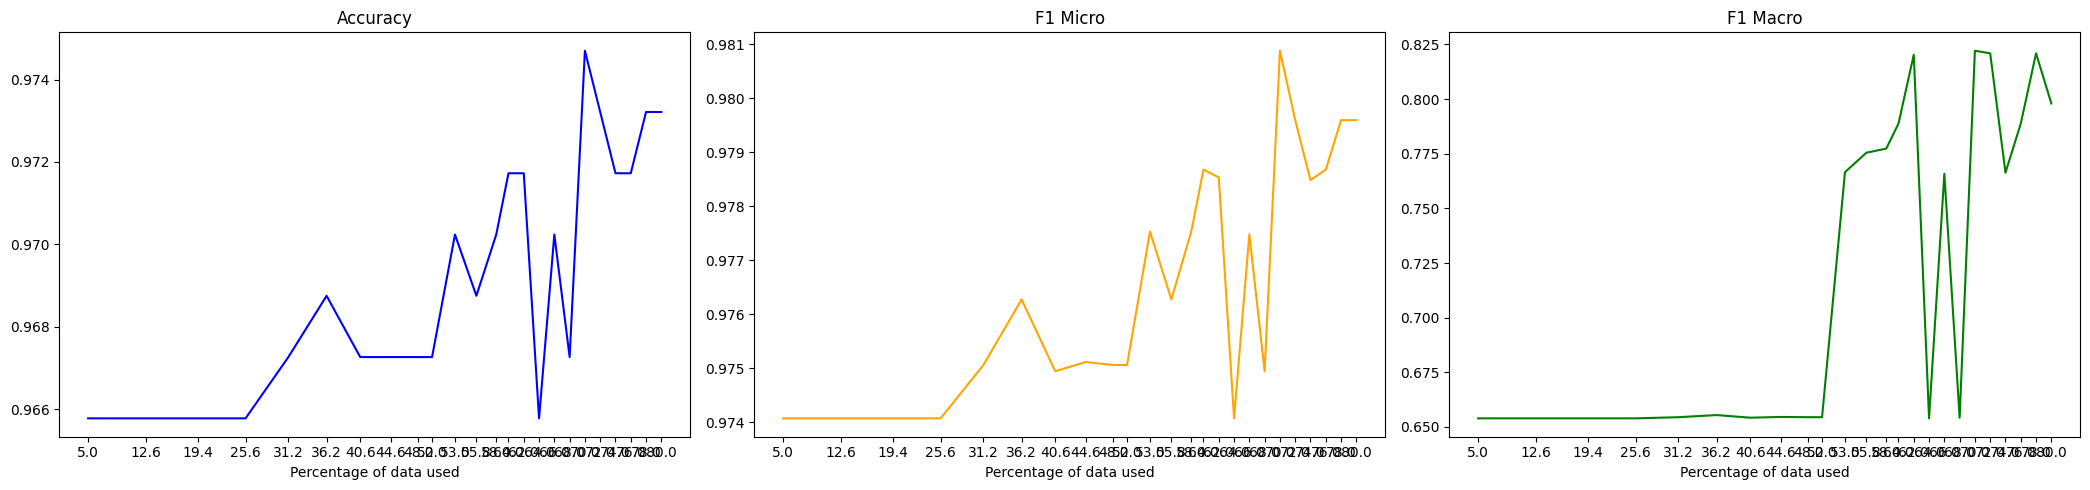

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6824, Accuracy: 0.933, F1 Micro: 0.9506, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2264, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2142, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.225, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5944, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.35, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2855, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2463, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1803, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1901, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1917, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1854, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.193, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1475, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1446, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1487, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1596, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1652

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1476, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1301, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1701, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1139, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2203, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1475, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1289, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 8/10, Train Loss: 0.1308, Accuracy: 0.9568, F1 Micro: 0.9667, F1 Macro: 0.6478
Epoch 9/10, Train Loss: 0.1167, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 8/10, Train Loss: 0.1216, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.1052, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1216, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1351, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6569
Epoch 9/10, Train Loss: 0.0928, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6569
Epoch 10/10, Train Loss: 0.0685, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2052, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1121, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9524, F1 Micro: 0.9644, F1 Macro: 0.703
Epoch 10/10, Train Loss: 0.0795, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3317, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7942
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7321
Epoch 10/10, Train Loss: 0.0497, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3291, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1926, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.153, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9539, F1 Micro: 0.9642, F1 Macro: 0.6454
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3026, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.311, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.301, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7182
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7431
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2989, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7453
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7453
Epoch 10/10, Train Loss: 0.0469, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1461, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9688, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2938, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7356
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7336
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7578
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7551
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1777, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.732
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1423, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7394
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7323
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Mac

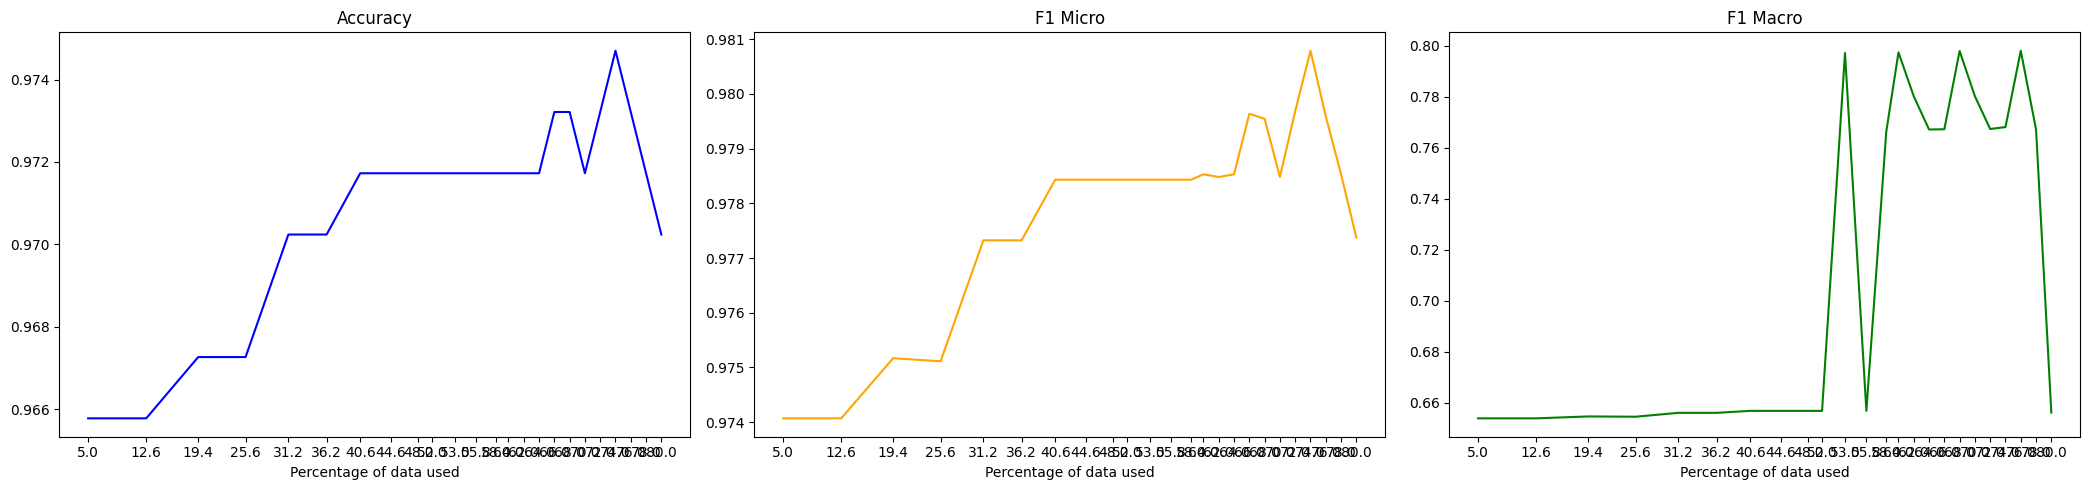

In [21]:
active_learning(seeds[4], 4)